In [1]:
import torch
import torchvision

# MLP for MNIST Classification

This notebook trains a **Multilayer Perceptron (MLP)** to classify **MNIST** digits (0–9). Below is a concise theory guide to frame each step of the pipeline.

---

## 1) Problem setup

- **Inputs**: grayscale images $x ∈ ℝ^{1×28×28}$ (values in `[0,1]` after `ToTensor`).
- **Flattening**: we reshape to a vector $x_{vec} ∈ ℝ^{784}$ (since `28×28=784`) before feeding the MLP.
- **Targets**: integer class labels `y ∈ {0,…,9}`.
- **Goal**: learn a function $f_θ : ℝ^{784} → ℝ^{10}$ that predicts the correct digit.

> **Why flatten?** Convolutional nets (CNNs) exploit spatial structure; an MLP doesn’t. Here we use a simpler **fully-connected** network that treats each pixel as a feature.

---

## 2) Model: Multilayer Perceptron (MLP)

An MLP stacks **linear layers** with **nonlinear activations**:

$$ x (784) → Linear(784→300) → ReLU → Linear(300→300) → ReLU → Linear(300→10) → logits $$

- **Linear layer**: `h = W x + b`.
- **ReLU**: `ReLU(z) = max(0, z)` adds nonlinearity so the network can learn complex functions.
- **Output**: a length-10 vector of **logits** (unnormalized scores), one per class.

**Parameter count (for this exact architecture):**
- `784×300 + 300 = 235,500`
- `300×300 + 300 = 90,300`
- `300×10  + 10  = 3,010`  
**Total ≈ 328,810 parameters**

> **Why logits (not probabilities)?** Computing probabilities via softmax is deferred to the loss function for numerical stability and correct gradients.

---

## 3) From logits to probabilities

For a sample `x`, the network outputs logits $z ∈ ℝ^{10}$. The **softmax** turns logits into probabilities:
$$
p_k = \frac{e^{z_k}}{\sum_{j=1}^{10} e^{z_j}}
$$
But in PyTorch, **you should not apply softmax before the loss** if you use `CrossEntropyLoss`.

> **PyTorch note**: `nn.CrossEntropyLoss(logits, y)` internally does `log_softmax` + `NLLLoss`. Give it **raw logits** and integer labels `y`.

---

## 4) Loss: Multi-class cross-entropy

For a single example with true class `y`, the cross-entropy loss is:
$$
\mathcal{L} = -\log p_y
$$
Averaged over the batch, this encourages the model to put high probability mass on the true class.

**Useful gradient fact** (with softmax + cross-entropy):
$$
\frac{\partial \mathcal{L}}{\partial z_k} = p_k - \mathbb{1}[k=y]
$$
i.e., the gradient on the logits is simply **(predicted prob − one-hot target)**.

---

## 5) Optimization: Gradient descent & Adam

Training iteratively improves parameters by following the negative gradient of the loss:
$$
\theta \leftarrow \theta - \eta \, \nabla_\theta \mathbb{E}_{(x,y)}[\mathcal{L}(f_\theta(x), y)]
$$

- **Mini-batches**: use `DataLoader` to estimate gradients on small batches (e.g., 32 samples) → faster, smoother updates.
- **Adam optimizer**: an adaptive variant of SGD that maintains running estimates of first/second moments of gradients. Typical start: `lr=1e-3`.

> **Epoch** = one full pass over the training set. Accuracy typically improves over multiple epochs.

---

## 6) Data preprocessing

- **`ToTensor()`** scales pixel values from `[0,255]` to `[0,1]`.
- **Normalization (recommended)**:
  $$
  x \leftarrow \frac{x - 0.1307}{0.3081}
  $$
  These are standard MNIST mean/std. Normalization can stabilize and speed convergence.

---

## 7) Evaluation: from logits to predictions

- **Predicted class**: $ŷ = argmax_k z_k$ (or `argmax` over probabilities; both equivalent).
- **Accuracy**:
  $$
  \text{acc} = \frac{\#\{i : \hat{y}_i = y_i\}}{N}
  $$
- **Confusion matrix (optional)**: shows which digits the model confuses (e.g., 4 vs 9).

> **Important**: Disable dropout/batch-norm effects and gradients at test time:
```python
net.eval()
with torch.no_grad():
    ...
```

## 8) Overfitting, regularization, and sanity checks

- **Overfitting**: training accuracy ≫ test accuracy.  
  Remedies: more data, **weight decay** (L2), **dropout**, reduce hidden size, early stopping.
- **Underfitting**: both train and test accuracy are low.  
  Remedies: train longer, increase model capacity, tune LR.
- **Sanity checks**:
  - Can the model **overfit a tiny subset** (e.g., 100 samples)? If not, something’s wrong (bugs, LR too low, etc.).
  - Does loss decrease over iterations? If not, check LR, device placement, label dtype, and that you’re using logits with `CrossEntropyLoss`.

---

## 9) Device, dtype, and reproducibility

- **Device**: keep model and tensors on the same device:
```python
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device); x, y = x.to(device), y.to(device)

```
- **Seeds** (help reproducibility, not exact determinism across all backends):
```python
import torch, random, numpy as np
torch.manual_seed(0); np.random.seed(0); random.seed(0)

```
- **Mixed precision** (optional): torch.cuda.amp.autocast() can speed training on GPU.


In [2]:
from torchvision import datasets, transforms

train_ds = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_ds = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

print(train_ds)
print(test_ds)

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 342kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.73MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.16MB/s]

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


## Why are MNIST pixel values between 0 and 1?

This happens because we applied **`transforms.ToTensor()`** when creating the dataset.

- Original MNIST images are stored as `uint8` with values in **[0, 255]**.
- `ToTensor()` converts the image into a `float32` PyTorch tensor and **divides every pixel by 255**.
- Result: pixel intensities are now floats in **[0.0, 1.0]**.

Examples:
- Black pixel → `0/255 = 0.0`
- White pixel → `255/255 = 1.0`
- Mid-gray pixel → `128/255 ≈ 0.502`

---

### Why scale to [0,1]?
- Neural networks train more stably with inputs in a small, consistent range.
- If we left values in `[0,255]`, the optimization could become unstable.

---

### Optional: Normalization
It’s common to normalize MNIST further using its dataset statistics:

```python
transforms.Normalize((0.1307,), (0.3081,))
```
* Mean ≈ 0.1307, Std ≈ 0.3081
* This shifts and rescales pixels to have mean ≈ 0 and variance ≈ 1.
* Helps the optimizer converge faster and more reliably.


4
[channels, height, width] :  torch.Size([1, 28, 28])
tensor(0.) tensor(1.)


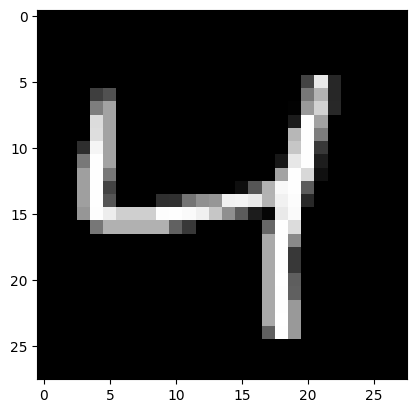

In [3]:
x, y = train_ds[2]
print(y)
print("[channels, height, width] : ", x.shape)

print(x.min(), x.max())

import matplotlib.pyplot as plt 
plt.imshow(x[0], cmap="gray")

In [4]:
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__() 

        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(28*28, 300),
            torch.nn.ReLU(), 
            torch.nn.Linear(300, 300),
            torch.nn.ReLU(), 
            torch.nn.Linear(300, 10)
        )

    def forward(self, x):
        return self.mlp(x.reshape(-1,28*28))


net = MLP()  
x, y = train_ds[0] 
probs = torch.softmax(net(x), dim=1)
print(y)
print([f"{p:.2f}" for p in probs[0].tolist()])

5
['0.10', '0.10', '0.11', '0.10', '0.11', '0.10', '0.09', '0.10', '0.10', '0.10']


## Understanding `CrossEntropyLoss`, logits, predictions, and labels

### Logits
- The output of the model before any softmax is called **logits**.  
- For MNIST, the shape is `(batch_size, 10)` because there are 10 digit classes.  
- Each row contains unnormalized scores, which can be any real numbers.

### Labels
- The true targets (`y`) are integer class indices, **not one-hot vectors**.  
- Example: if the true digit is "3", the label is simply `3`.

### How `CrossEntropyLoss` works
- In PyTorch, `nn.CrossEntropyLoss` expects:
  - **logits** of shape `(N, C)` where `N` = batch size and `C` = number of classes.  
  - **labels** of shape `(N,)` containing integers in `[0, C-1]`.  
- Internally it applies:
  1. `log_softmax` to convert logits into log-probabilities.  
  2. Negative log-likelihood loss comparing these log-probabilities with the true labels.

This means **you should not apply softmax before passing logits to the loss**.  
Doing so would double-apply softmax and give incorrect results.

### Predictions
- For accuracy, we turn logits into predicted class indices using `argmax` along the class dimension:
  
      preds = logits.argmax(dim=1)

- This gives a tensor of shape `(N,)` with the most likely class per sample.

---

### Recap
- **Logits** = raw model outputs (any real values).  
- **Labels** = integer class indices (0–9 for MNIST).  
- **CrossEntropyLoss** = combines softmax + negative log-likelihood, so you give it logits + labels directly.  
- **Predictions** = `argmax` over logits when you want to evaluate accuracy.


In [5]:
from tqdm import tqdm 

train_dl = torch.utils.data.DataLoader(
    train_ds, 
    batch_size=32, 
    shuffle=True
)

net = MLP()
optimizer = torch.optim.Adam(
    net.parameters(), 
    lr=0.001
)
loss_fn = torch.nn.CrossEntropyLoss()

for x,y in tqdm(train_dl):
    predicted_y = net(x)
    loss = loss_fn(predicted_y, y) 

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

100%|██████████| 1875/1875 [00:15<00:00, 117.22it/s]


## Collecting predictions and labels with `.tolist()`

In the evaluation loop we often see:

    preds.extend(y_model.argmax(dim=1).tolist())
    actuals.extend(y.tolist())

- `y_model.argmax(dim=1)` gives a tensor of predicted class indices for the batch  
  (for example: tensor([3, 1, 7, 4]) if the batch size is 4).  
- `y` is a tensor of true labels for that batch  
  (for example: tensor([3, 0, 7, 4])).  
- `.tolist()` converts these tensors into regular Python lists:  
  - [3, 1, 7, 4]  
  - [3, 0, 7, 4]  

### Why use `.tolist()`?
- `list.extend()` expects a Python iterable (like a list), not a tensor.  
- Without `.tolist()`, you might get an error or end up with a list of tensors.  
- With `.tolist()`, `preds` and `actuals` become plain lists of integers, which are easy to compare later.

---

### Alternative
We could also keep everything as tensors and concatenate at the end:

    all_preds = torch.cat(pred_batches)
    all_actuals = torch.cat(label_batches)
    accuracy = (all_preds == all_actuals).float().mean()

Both methods work; converting to lists is just a simpler, teaching-friendly approach.


In [6]:
test_dl = torch.utils.data.DataLoader(
    test_ds, 
    batch_size=32, 
    shuffle=True
)

preds = []
actuals = []

for x,y in test_dl:
    y_model = net(x)
    preds.extend(y_model.argmax(dim=1).tolist())
    actuals.extend(y.tolist())